In [2]:
from math import cos, sin, asin, acos, gcd, atan2
import numpy as np
from numpy import array, dot, degrees, cross
from numpy.linalg import inv, det, solve, norm
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# import the python scripts:
import gb_code.csl_generator as csl

%matplotlib notebook

## Produce Lists of CSL boundaries for any given rotation axis (hkl) :


In [2]:
# for example: [1, 0, 0], [1, 1, 0] or [1, 1, 1]
axis = np.array([1,1,1])

# list Sigma boundaries < 50
csl.print_list(axis,50)

Sigma:     1  Theta:   0.00 
Sigma:     3  Theta:  60.00 
Sigma:     7  Theta:  38.21 
Sigma:    13  Theta:  27.80 
Sigma:    19  Theta:  46.83 
Sigma:    21  Theta:  21.79 
Sigma:    31  Theta:  17.90 
Sigma:    37  Theta:  50.57 
Sigma:    39  Theta:  32.20 
Sigma:    43  Theta:  15.18 
Sigma:    49  Theta:  43.57 


## Select a sigma and get the characteristics of the GB:


In [3]:
# pick a sigma for this axis, ex: 7.
sigma = 7

theta, m, n = csl.get_theta_m_n_list(axis, sigma)[0]

R = csl.rot(axis, theta)

# Minimal CSL cells. The plane orientations and the orthogonal cells
# will be produced from these original cells.
M1, M2 = csl.Create_minimal_cell_Method_1(sigma, axis, R)

print('Angle:', degrees(theta), '\n', 'Sigma:', sigma,'\n', 
      'Minimal cells:','\n', M1,'\n', M2, '\n')

Angle: 38.21321070173819 
 Sigma: 7 
 Minimal cells: 
 [[ 1  2  1]
 [ 0 -1  1]
 [-2  0  1]] 
 [[ 0  2  1]
 [ 1  0  1]
 [-2 -1  1]] 



## Produce Lists of GB planes for the chosen boundary :


In [5]:
# the higher the limit the higher the indices of GB planes produced.

lim = 5

V1, V2, M, Gb = csl.Create_Possible_GB_Plane_List(axis, m,n,lim)


In [6]:
# the following data frame shows the created list of GB planes and their corresponding types
df = pd.DataFrame(
    {'GB1': list(V1),
     'GB2': list(V2),
     'Type': Gb
    })

df.head()

,GB1,GB2,Type
0,"[-2, 1, 0]","[-2, 0, 1]",Mixed
1,"[-1, -1, -1]","[-1, -1, -1]",Twist
2,"[1, 1, 1]","[1, 1, 1]",Twist
3,"[-1, 0, 2]","[0, -1, 2]",Mixed
4,"[2, -1, 0]","[2, 0, -1]",Mixed


In [7]:
# Only show the twist boundaries in this system: 
 
df[df['Type'] == 'Twist'].head()

,GB1,GB2,Type
1,"[-1, -1, -1]","[-1, -1, -1]",Twist
2,"[1, 1, 1]","[1, 1, 1]",Twist


## Select a GB plane and go on:
### You only need to pick the GB1 plane


In [10]:
# choose a basis and a boundary plane:

basis = 'fcc'

v1 = np.array([1, 1, 1])

# find its orthogonal cell

O1, O2, Num = csl.Find_Orthogonal_cell(basis, axis, m, n, v1)

In [11]:
# function to plot the dichromatic pattern on
# plane v1 (atoms from grain one, grain two and the overlapped CSL points)

def PlotPlane(v1, lim=6, plane_thickness=0.1):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    v = dot(R, v1)
         
    x = np.arange(-lim,lim)
    y = np.arange(-lim,lim)
    z = np.arange(-lim,lim)

    V = len(x)*len(y)*len(z)
    indice = (np.stack(np.meshgrid(x, y, z)).T).reshape(V, 3)
    
    # import basis 
    Base = csl.Basis(str(basis))
    Atoms1 = []
    vecs = []
    tol =  0.001
    
    # create lattice
    for i in range(V):
        for j in range(len(Base)):
            Atoms1.append(indice[i,0:3] + Base[j,0:3])
    Atoms1 = np.array(Atoms1) 
    
    # plot atoms of one grain on a given plane
    for i in range(len(Atoms1)):
        if abs(dot(Atoms1[i],v)) <= plane_thickness:
            ax.scatter(Atoms1[i,0],Atoms1[i,1],Atoms1[i,2],'s', s = 5, 
                       facecolor = 'k',edgecolor='k')
    
    # plot atoms of the other grain on a given plane        
    Atoms2 = dot(R,Atoms1.T).T
    for i in range(len(Atoms2)):
        if abs(dot(Atoms2[i],v)) <= plane_thickness:     
            ax.scatter(Atoms2[i,0], Atoms2[i,1], Atoms2[i,2],'s', s = 50, 
                       facecolor = 'g',edgecolor='g', alpha=0.2)
    
    # create the CSL lattice  
    csl_cell = np.round(dot(R,csl.CSL_vec(basis, M1)),7)
    for i in range(V):
        vector = (indice[i, 0] * csl_cell[:, 0] + indice[i, 1] * csl_cell[:, 1] + indice[i, 2] * csl_cell[:, 2])
        vecs.append(vector)
    
    # plot the CSL atoms on a given plane   

    vecs = np.array(vecs)        
    for i in range(len(vecs)):
        if abs(dot(vecs[i],v)) <= plane_thickness :
            ax.scatter(vecs[i,0],vecs[i,1],vecs[i,2],'o', s=100, 
                        facecolor = 'y',edgecolor='y', alpha=0.3)                

    ax.set_proj_type('ortho')
    ax.axis('scaled')    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)

    ax.grid(False)
    
    # view direction: normal to the plane
    
    az = degrees(atan2(v[1],v[0]))
    el = degrees(asin(v[2]/norm(v)))
    ax.view_init(azim = az, elev = el)       
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')                      
    ax.set_zlabel('Z axis')  
    
    return ax   


### Plot the twist boundary plane with the DSC vectors (the small CSL repeat vectors)


#### _DSC vectors are the smallest vectors that keep the symmetry of the CSL lattice intact. They are therefore possible Burgers vectors of grain boundary dislocations. To know more about this I refer you to: 'Interfaces in crystalline materials', Sutton and Balluffi, clarendon press, 1996._ 

<IPython.core.display.Javascript object>


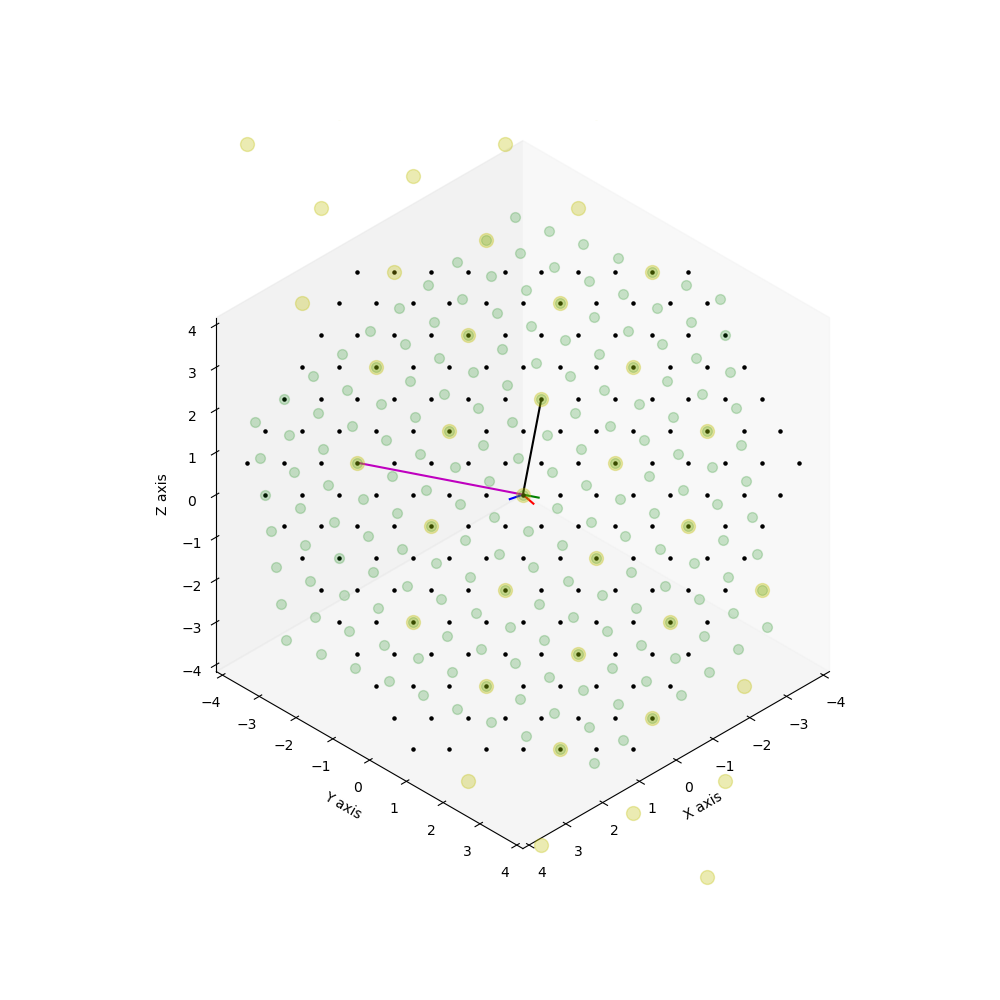

In [12]:
%matplotlib notebook
ax = PlotPlane(v1, lim=4)

# function to plot a line 
def PlotLine(Vec, origin=[0,0,0], length=1, color='k'):    
    return (ax.plot([origin[0], length*Vec[0] + origin[0]], 
       [origin[1], length*Vec[1] + origin[1]],
       [origin[2], length*Vec[2]+ origin[2]], str(color)))


# plot the DSC vectors network, if you want the projected vectors on the plane use csl.DSC_on_plane
dsc_cell = np.round(dot(R,1/sigma*csl.DSC_vec(basis,sigma, M1)),7)

PlotLine(dsc_cell[:,0], color='r') 
PlotLine(dsc_cell[:,1], color='b')
PlotLine(dsc_cell[:,2], color='g')  

#Plot the orthogonal CSL vectors on the v1 plane

PlotLine(O2[:,1], color='k')
PlotLine(O2[:,2], color='m')

### A more advanced example of the usage of the CSL lattice in creating large facets:

####  _This is how I created a large two-faceted structure by decomposing the high index boundary plane onto two lower energy facets. All the 3 planes are CSL planes and form a triangle. To know more follow the link to the paper:_ __(https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.043601)__

In [13]:
df[df['Type'] == 'Tilt'].head()

,GB1,GB2,Type
98,"[-5, 4, 1]","[-5, 1, 4]",Tilt
103,"[4, 1, -5]","[1, 4, -5]",Tilt
114,"[5, -4, -1]","[5, -1, -4]",Tilt
116,"[-4, -1, 5]","[-1, -4, 5]",Tilt
268,"[7, 0, -7]","[3, 5, -8]",Tilt


In [14]:
v1 = np.array([-5, 4, 1])

O1, O2, Num = csl.Find_Orthogonal_cell(basis,axis,m,n,v1)

<IPython.core.display.Javascript object>


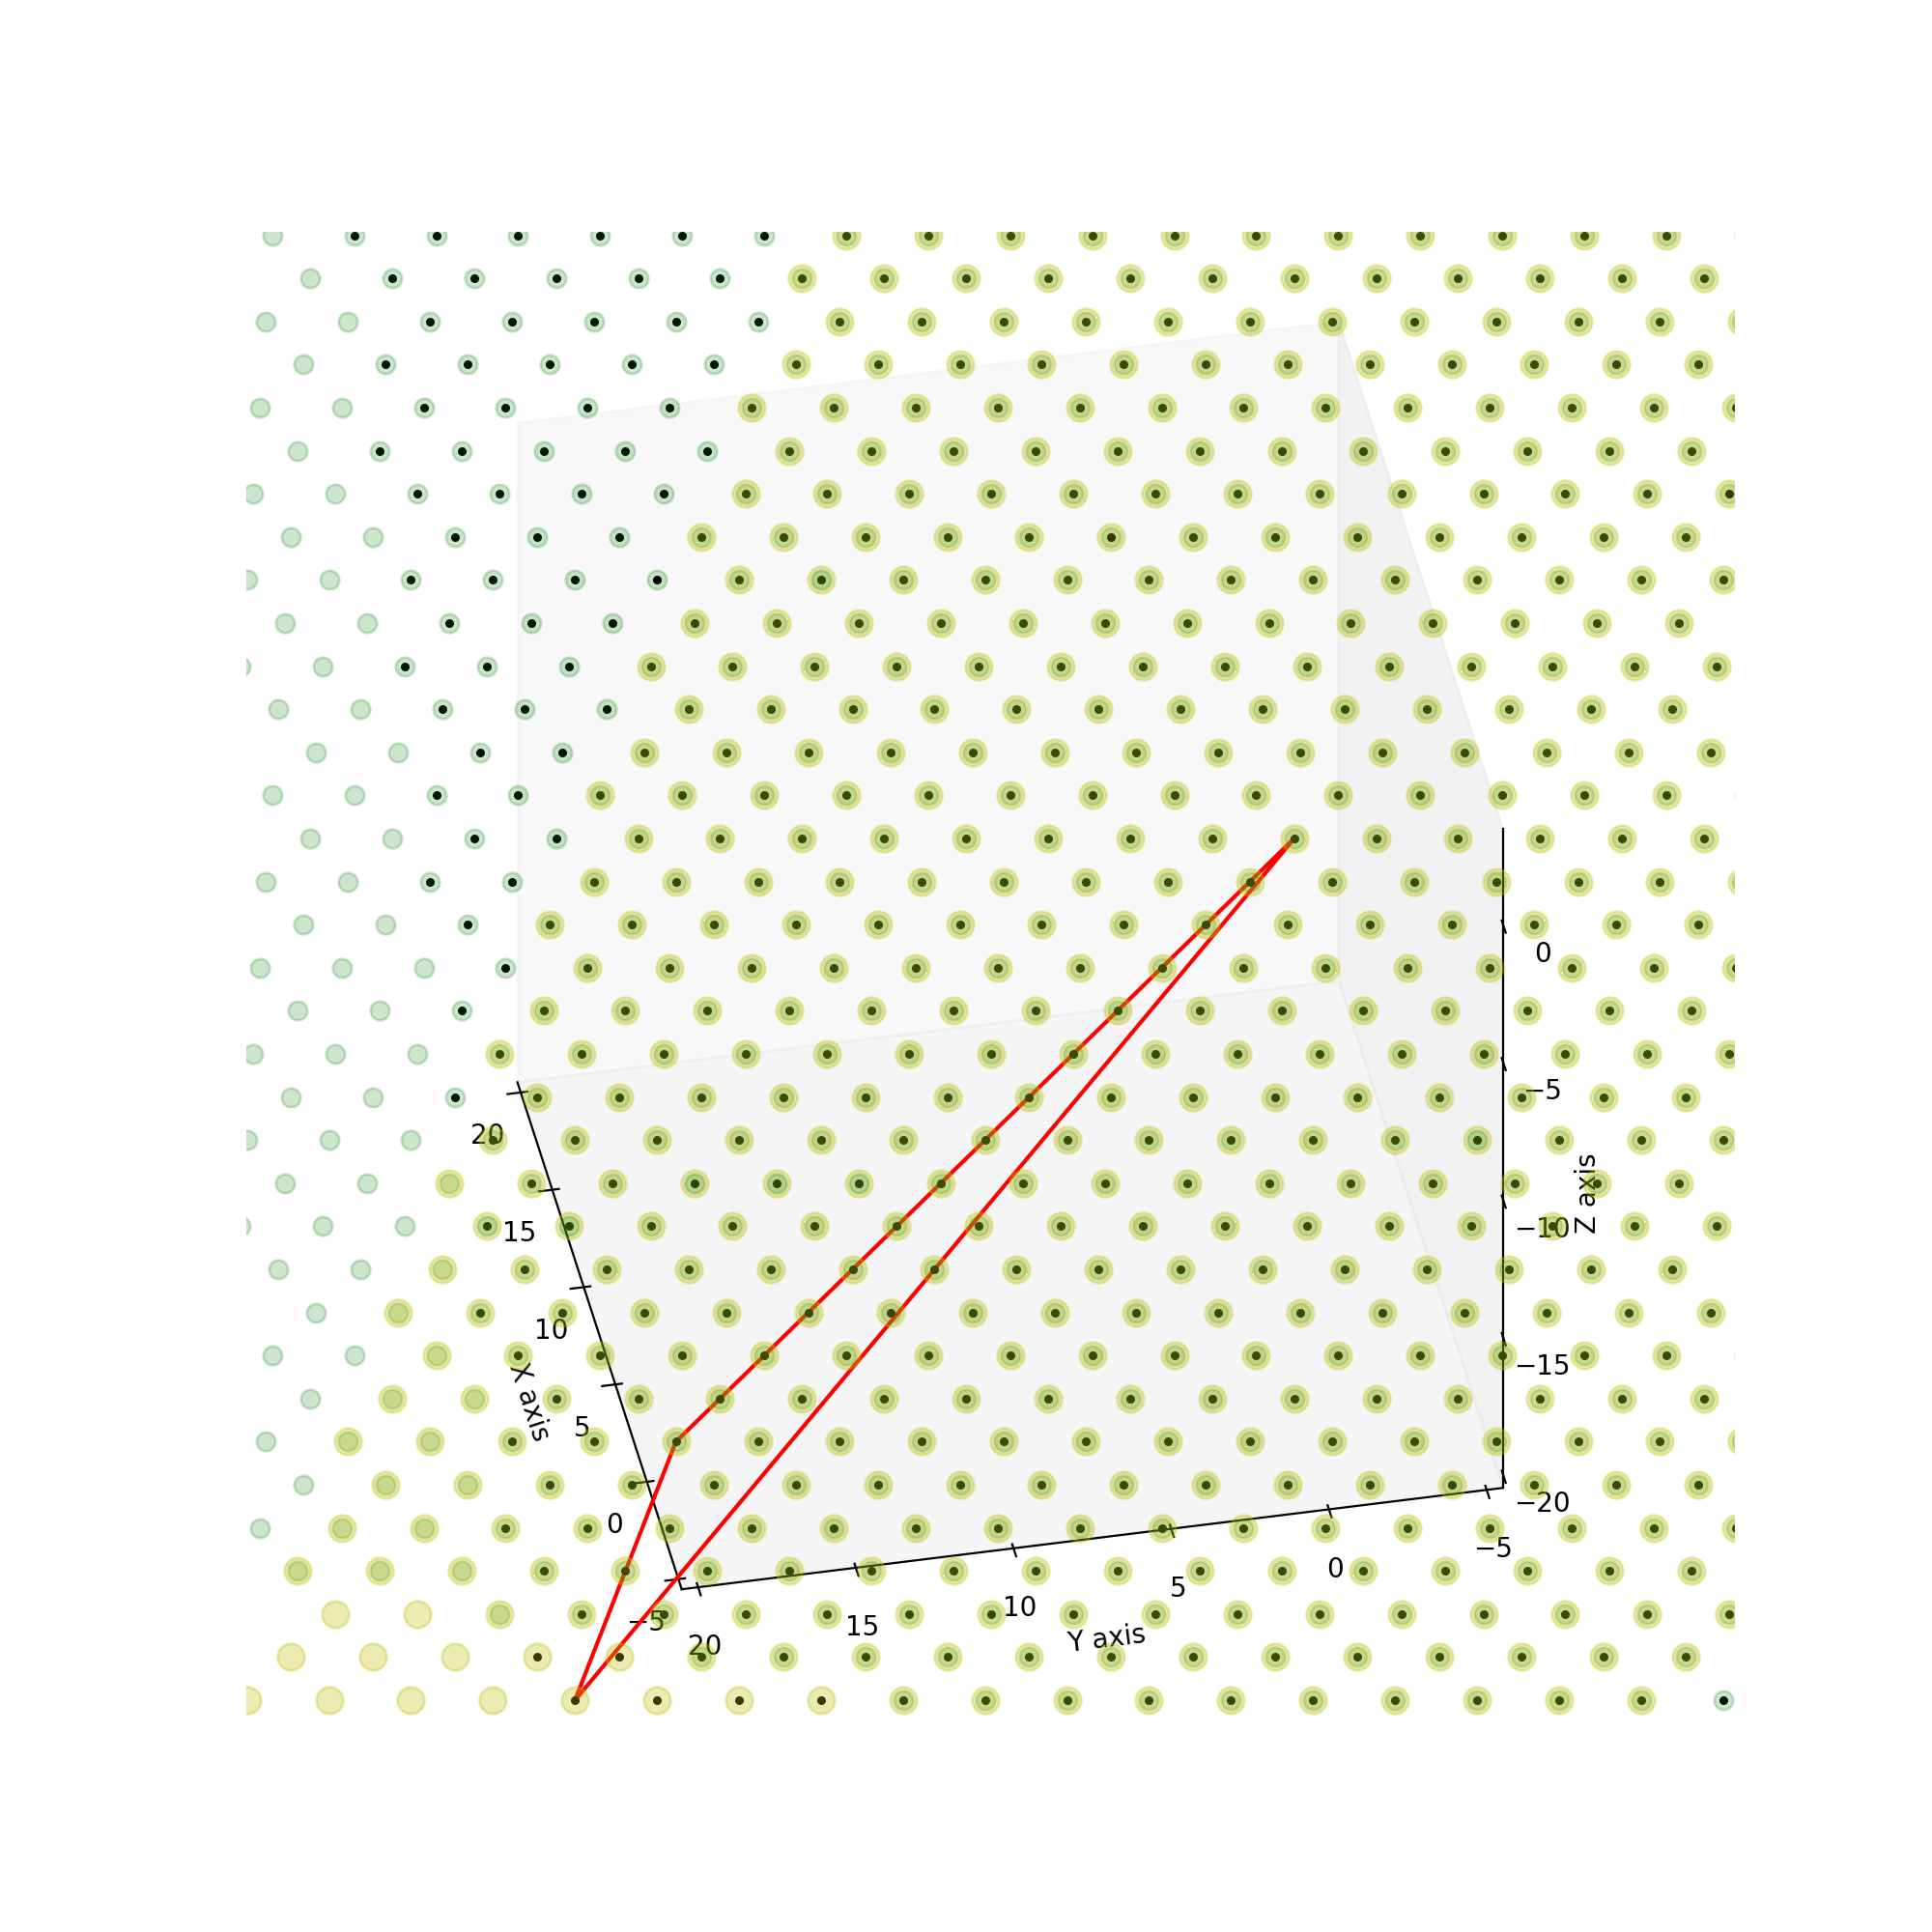

(-20, 3)

In [24]:
ax = PlotPlane(v1, lim=27)

# I intended to decompose the mixed grain boundary (7, 16, -29) into two lower energy facets.
# 1 unit vector of (7, 16, -29) = 7 units of (1 2 3) plane + 2 units of (0 1 4). 

PlotLine(dot(R,[7, 16, -29]), color='r')
PlotLine(dot(R,[1, 2, -3]), length=7, color='r')
PlotLine(dot(R,[0, 1, -4]), origin=dot(R,7*np.array([1, 2, -3])), length=2, color='r') 
ax.set_xlim(-5, 20)
ax.set_ylim(-5, 20)
ax.set_zlim(-20, 3)

